# Multicriteria Spatial Analysis: Ideal retirement areas in Colombia   
# Part I

Geoprocesamiento 2025-1S  
Universidad Nacional de Colombia  
Authors: Alicia Arévalo Robinson and Ricardo Andrés Martinez Soto  
Link to repository:

#### **Objective**
To identify the most suitable areas for retirement living in Colombia, considering climate, accessibility, medical services, and the quality of the natural environment.

## Import modules

In [5]:
import geopandas as gpd       # used to handle shapefiles and other vector spatial data in Python
import numpy as np
import rasterio
import rasterio.plot
import matplotlib.pyplot as plt  # Library for creating visualisations
import scipy.ndimage
import scipy.stats
import rasterio.merge
import rasterio.features
import matplotlib.pyplot as plt
from osgeo import gdal

## Read data

In [13]:
# Mean temperature
temp_path="./data/temperatura/SHP/ACC2014_TmMd_AA_1981_2010.shp"
# DEM Colombia
dem_col_path="./data/dem_colombia/SRTM30/SRTM_30_Col1.tif"
# Protected areas
runap_path="./data/areas_protegidas/runap.shp"
# Titulos mineros
min_path="./data/mineria_hidrocarburos/AreasMineriaeHidrocarburos.gpkg"
# Indigenous reserves
indigenous_path="./data/Resguardo_Indigena_Formalizado/Resguardo_Indigena_Formalizado.shp"
# Public services coverage
services_path="./data/acueducto/CoberturaServiciosPublicos.gpkg"
# Roads
road_path="./data/VIAS/VIAS.shp"
# Land cover
cover_path="./data/cover/cobertura_tierra_clc_2018.shp"
# Municipalities of Colombia
muni_path="./data/muni_category/municipios.shp"
# Populated Center
popcenter_path="./data/MGN2024_URB_ZONA_URBANA/MGN_URB_ZONA_URBANA.shp"
# Cundinamarca boundary
cundi_path="./data/cundinamarca.shp"

#### Read GeoDataFrames

In [19]:
# Read and project to EPSG:9377
#temp= gpd.read_file(temp_path).to_crs(epsg=9377)
#runap = gpd.read_file(runap_path).to_crs(epsg=9377)
#min = gpd.read_file(min_path).to_crs(epsg=9377)
#indigenous = gpd.read_file(indigenous_path).to_crs(epsg=9377)
#services = gpd.read_file(services_path).to_crs(epsg=9377)
#cover = gpd.read_file(cover_path).to_crs(epsg=9377)
muni = gpd.read_file(muni_path).to_crs(epsg=9377)
#road = gpd.read_file(road_path).to_crs(epsg=9377)
popcenter= gpd.read_file(popcenter_path).to_crs(epsg=9377)
#cundi= gpd.read_file(cundi_path).to_crs(epsg=9377)

### Filter

In [24]:
road = road[road["type"].isin([
    "primary", 
    "primary link", 
    "secondary", 
    "secondary link", 
    "tertiary", 
    "tertiary link", 
    "residential"
])]

muni = muni[muni["Ley6172000"].isin(["1","2","3"])]

popcenter = popcenter[popcenter["clas_ccdgo"].isin(["1"])]

### Clip

In [25]:
temp = gpd.overlay(temp, cundi, how='intersection')
runap = gpd.overlay(runap, cundi, how='intersection')
min = gpd.overlay(min, cundi, how='intersection')
indigenous = gpd.overlay(indigenous, cundi, how='intersection')
services = gpd.overlay(services, cundi, how='intersection')
cover = gpd.overlay(cover, cundi, how='intersection')
muni = gpd.overlay(muni, cundi, how='intersection')
popcenter = gpd.overlay(popcenter, cundi, how='intersection')
road = gpd.overlay(road, cundi, how='intersection')

C:\Users\VICTUS\AppData\Local\Temp\ipykernel_5312\3855386913.py:2: UserWarning: `keep_geom_type=True` in overlay resulted in 24 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  runap = gpd.overlay(runap, cundi, how='intersection')


In [26]:
# Remove one of the duplicate columns before saving
if 'SHAPE_Leng' in road.columns and 'Shape_Leng' in road.columns:
    road = road.drop(columns=['Shape_Leng'])  


In [27]:
services = services[services['COD_MPIO'].astype(str).str.startswith('25')]

In [ ]:
# Remove duplicate columns before saving each layer
if 'SHAPE_Leng' in muni.columns and 'Shape_Leng' in muni.columns:
    muni = muni.drop(columns=['Shape_Leng'])
if 'SHAPE_Area' in muni.columns and 'Shape_Area' in muni.columns:
    muni = muni.drop(columns=['Shape_Area'])

if 'SHAPE_Leng' in road.columns and 'Shape_Leng' in road.columns:
    road = road.drop(columns=['Shape_Leng'])
if 'SHAPE_Area' in road.columns and 'Shape_Area' in road.columns:
    road = road.drop(columns=['Shape_Area'])

save

In [32]:
# Define output GeoPackage path
output_gpkg = "./data/clip/clipped_layers.gpkg"

# Save each GeoDataFrame as a separate layer in the GeoPackage
temp.to_file(output_gpkg, layer='temp', driver="GPKG")
runap.to_file(output_gpkg, layer='runap', driver="GPKG")
min.to_file(output_gpkg, layer='min', driver="GPKG")
indigenous.to_file(output_gpkg, layer='indigenous', driver="GPKG")
services.to_file(output_gpkg, layer='services', driver="GPKG")
cover.to_file(output_gpkg, layer='cover', driver="GPKG")
muni.to_file(output_gpkg, layer='muni', driver="GPKG")
road.to_file(output_gpkg, layer='road', driver="GPKG")

plot

C:\Users\VICTUS\AppData\Local\Temp\ipykernel_5312\2061530029.py:44: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  cover.plot(column="leyenda", ax=axs[2, 0], legend=False, color=cover["leyenda"].map(random_colors_cover))


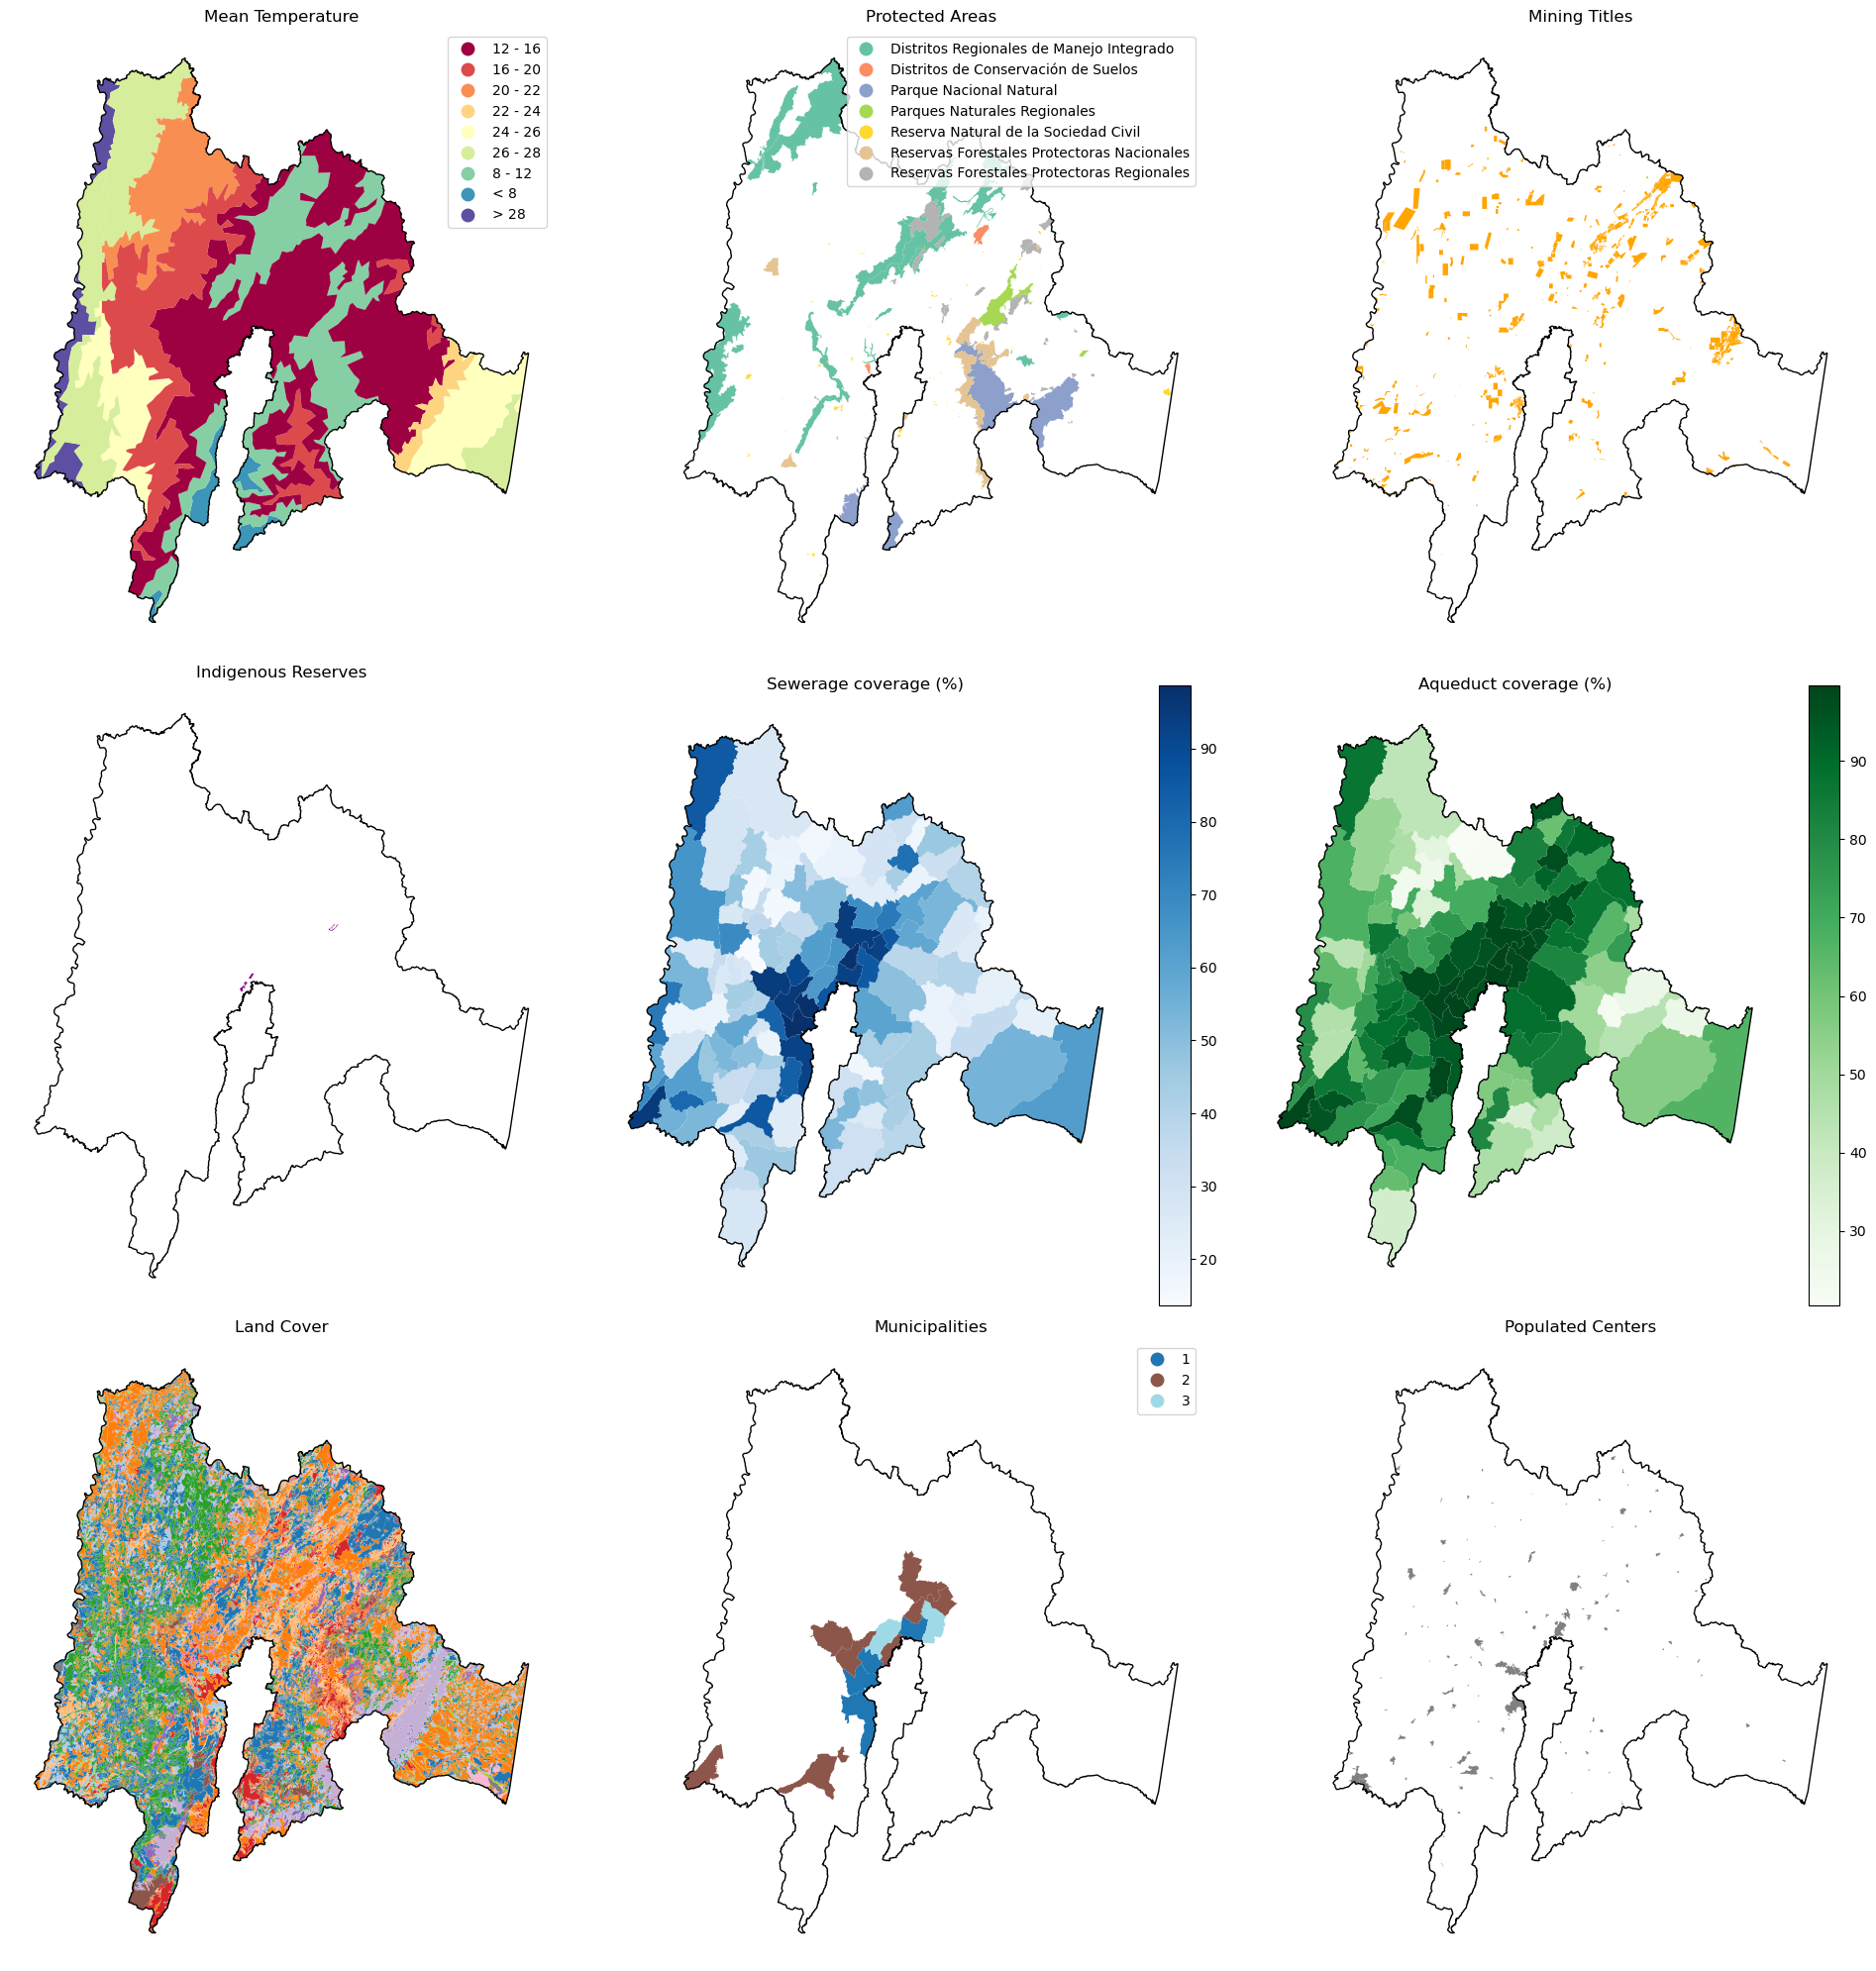

In [37]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(3, 3, figsize=(20, 20))

# 1. Temperature: color by "RANGO"
temp.plot(column="RANGO", ax=axs[0, 0], legend=True, cmap="Spectral")
cundi.boundary.plot(ax=axs[0, 0], color="black", linewidth=1)
axs[0, 0].set_title("Mean Temperature")
axs[0, 0].set_axis_off()

# 2. Runap: color by "ap_categor"
runap.plot(column="ap_categor", ax=axs[0, 1], legend=True, cmap="Set2")
cundi.boundary.plot(ax=axs[0, 1], color="black", linewidth=1)
axs[0, 1].set_title("Protected Areas")
axs[0, 1].set_axis_off()

# 3. Min: single color (e.g., orange)
min.plot(ax=axs[0, 2], color="orange")
cundi.boundary.plot(ax=axs[0, 2], color="black", linewidth=1)
axs[0, 2].set_title("Mining Titles")
axs[0, 2].set_axis_off()

# 4. Indigenous: single color (e.g., purple)
indigenous.plot(ax=axs[1, 0], color="purple")
cundi.boundary.plot(ax=axs[1, 0], color="black", linewidth=1)
axs[1, 0].set_title("Indigenous Reserves")
axs[1, 0].set_axis_off()

# 5. Services: choropleth with two columns
services.plot(column="Cob__Alcan", ax=axs[1, 1], legend=True, cmap="Blues")
cundi.boundary.plot(ax=axs[1, 1], color="black", linewidth=1)
axs[1, 1].set_title("Sewerage coverage (%)")
axs[1, 1].set_axis_off()

services.plot(column="Cob__Acued", ax=axs[1, 2], legend=True, cmap="Greens")
cundi.boundary.plot(ax=axs[1, 2], color="black", linewidth=1)
axs[1, 2].set_title("Aqueduct coverage (%)")
axs[1, 2].set_axis_off()

# 6. Cover: random color for each "leyenda"
unique_leyenda = cover["leyenda"].unique()
random_colors_cover = dict(zip(unique_leyenda, plt.cm.tab20(np.linspace(0, 1, len(unique_leyenda)))))
cover.plot(column="leyenda", ax=axs[2, 0], legend=False, color=cover["leyenda"].map(random_colors_cover))
cundi.boundary.plot(ax=axs[2, 0], color="black", linewidth=1)
axs[2, 0].set_title("Land Cover")
axs[2, 0].set_axis_off()

# 7. Muni: random color for each Ley6172000
muni.plot(column="Ley6172000", ax=axs[2, 1], legend=True, cmap="tab20")
cundi.boundary.plot(ax=axs[2, 1], color="black", linewidth=1)
axs[2, 1].set_title("Municipalities")
axs[2, 1].set_axis_off()

# 8. Populated Center: single color 
popcenter.plot(ax=axs[2, 2], color="grey")
cundi.boundary.plot(ax=axs[2, 2], color="black", linewidth=1)
axs[2, 2].set_title("Populated Centers")
axs[2, 2].set_axis_off() 

plt.tight_layout()
plt.show()

In [38]:
with rasterio.open(dem_col_path) as src:
    dem_col = src.read(1)
    dem_col_meta = src.meta 

dem_col_meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -3.4028230607370965e+38,
 'width': 38951,
 'height': 51271,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["MAGNA_CTM12",GEOGCS["MAGNA-SIRGAS",DATUM["Marco_Geocentrico_Nacional_de_Referencia",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6686"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4686"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",4],PARAMETER["central_meridian",-73],PARAMETER["scale_factor",0.9992],PARAMETER["false_easting",5000000],PARAMETER["false_northing",2000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
 'transform': Affine(38.21851414258779, 0.0, 4280523.4007429285,
        0.0, -38.2185141425878, 2996969.6092570713)}

clip dem

In [39]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd

# Ensure geometry is in the same CRS as the raster
with rasterio.open(dem_col_path) as src:
    if cundi.crs != src.crs:
        cundi = cundi.to_crs(src.crs)

    # Get geometry as GeoJSON-like mapping
    geoms = cundi.geometry.values
    geoms = [geom.__geo_interface__ for geom in geoms]

    # Clip the raster
    dem_cundi, out_transform = mask(src, geoms, crop=True)
    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": dem_cundi.shape[1],
        "width": dem_cundi.shape[2],
        "transform": out_transform
    })

# Save the clipped raster
with rasterio.open("./data/raster/dem_cundi.tif", "w", **out_meta) as dest:
    dest.write(dem_cundi)

dem_cundi_path= "./data/raster/dem_cundi.tif"

In [40]:
with rasterio.open(dem_cundi_path) as src:
    dem_cundi = src.read(1)
    dem_cundi_meta = src.meta 

dem_cundi_meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -3.4028230607370965e+38,
 'width': 5336,
 'height': 6094,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["MAGNA_CTM12",GEOGCS["MAGNA-SIRGAS",DATUM["Marco_Geocentrico_Nacional_de_Referencia",SPHEROID["GRS 1980",6378137,298.257222101004,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6686"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4686"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",4],PARAMETER["central_meridian",-73],PARAMETER["scale_factor",0.9992],PARAMETER["false_easting",5000000],PARAMETER["false_northing",2000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
 'transform': Affine(38.21851414258779, 0.0, 4790243.723862622,
        0.0, -38.2185141425878, 2203209.2890296653)}

calculate slope

In [41]:
import os

cundi_slope  = os.path.splitext(dem_cundi_path)[0] + '_slope.tif'

os.system(f'gdaldem slope "{dem_cundi_path}" "{cundi_slope}" -of GTiff')

0

In [42]:
cundi_slope_path = "./data/raster/dem_cundi_slope.tif"

with rasterio.open(cundi_slope_path) as src:
    cundi_slope = src.read(1)
    cundi_slope_meta = src.meta
    slope_bounds = src.bounds


In [43]:
import numpy as np
print("Maximum slope (degrees):", np.nanmax(cundi_slope))

Maximum slope (degrees): 87.59907


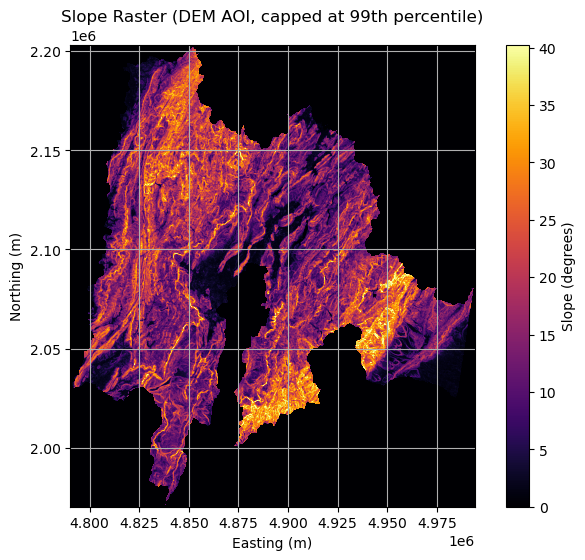

In [44]:
# Calculate extent for real-world coordinates
extent = [slope_bounds.left, slope_bounds.right, slope_bounds.bottom, slope_bounds.top]

# Cap color scale at 99th percentile for better visualization
vmax = np.percentile(cundi_slope, 99)

plt.figure(figsize=(8, 6))
plt.imshow(cundi_slope, cmap="inferno", extent=extent, origin='upper', vmin=0, vmax=vmax)
plt.colorbar(label="Slope (degrees)")
plt.title("Slope Raster (DEM AOI, capped at 99th percentile)")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.grid(True)
plt.show()

rasterisation

In [45]:
import rasterio
from rasterio.features import rasterize
import numpy as np

# Load reference parameters from the reprojected DEM 
with rasterio.open(dem_cundi_path) as src:
    dem_meta = src.meta
    transform = src.transform
    out_shape = (src.height, src.width)
    crs = src.crs

print("Reference transform and shape loaded from DEM")

#  Rasterise function 
def rasterise_layer(gdf, transform, out_shape, burn_value=1, layer_name="Layer"):
    """
    Rasterise a GeoDataFrame to match the reference raster grid.
    """
    if gdf.empty:
        print(f" {layer_name} is empty. Returning empty raster.")
        return np.zeros(out_shape, dtype="uint8")

    geometries = [(geom, burn_value) for geom in gdf.geometry if geom is not None]

    raster = rasterize(
        geometries,
        out_shape=out_shape,
        transform=transform,
        fill=0,
        dtype="uint8"
    )

    print(f" Rasterised: {layer_name}")
    return raster

#  Rasterise each vector layer 
runap_raster = rasterise_layer(runap, transform, out_shape, layer_name="runap")
min_raster = rasterise_layer(min, transform, out_shape, layer_name="min")
indigenous_raster = rasterise_layer(indigenous, transform, out_shape, layer_name="indigenous")
road_raster = rasterise_layer(road, transform, out_shape, layer_name="road")
popcenter_raster = rasterise_layer(popcenter, transform, out_shape, layer_name="popcenter")


Reference transform and shape loaded from DEM
 Rasterised: runap
 Rasterised: min
 Rasterised: indigenous
 Rasterised: road
 Rasterised: popcenter


export

In [48]:
# Use the DEM metadata as a template, but update count and dtype
meta = dem_meta.copy()
meta.update({
    "count": 1,
    "dtype": "uint8",
    "nodata": 255  # Use 255 as nodata for uint8
})

with rasterio.open("./data/raster/runap_raster.tif", "w", **meta) as dst:
    dst.write(runap_raster, 1)

with rasterio.open("./data/raster/min_raster.tif", "w", **meta) as dst:
    dst.write(min_raster, 1)

with rasterio.open("./data/raster/indigenous_raster.tif", "w", **meta) as dst:
    dst.write(indigenous_raster, 1)

with rasterio.open("./data/raster/road_raster.tif", "w", **meta) as dst:
    dst.write(road_raster, 1)

with rasterio.open("./data/raster/popcenter_raster.tif", "w", **meta) as dst:
    dst.write(popcenter_raster, 1)

rasterize temperature

In [49]:
# Rasterize the temperature layer using the "RANGO" column
# Assign a unique value to each RANGO category

# Create a dictionary of unique values for each RANGO
rango_vals = {cat: i+1 for i, cat in enumerate(sorted(temp["RANGO"].unique()))}

# Create geometries with the corresponding RANGO value
geometries = [
    (geom, rango_vals[rango])
    for geom, rango in zip(temp.geometry, temp["RANGO"])
    if geom is not None
]

# Rasterize
from rasterio.features import rasterize

temp_raster = rasterize(
    geometries,
    out_shape=out_shape,
    transform=transform,
    fill=0,
    dtype="uint8"
)

print("Temperature rasterization completed. Value legend:")
for k, v in rango_vals.items():
    print(f"{v}: {k}")

Temperature rasterization completed. Value legend:
1: 12 - 16
2: 16 - 20
3: 20 - 22
4: 22 - 24
5: 24 - 26
6: 26 - 28
7: 8 - 12
8: < 8
9: > 28


In [50]:
temp_raster_path = "./data/raster/temp_raster.tif"

# Use the DEM metadata as a template, but update count and dtype
meta = dem_meta.copy()
meta.update({
    "count": 1,
    "dtype": "float32"
})

with rasterio.open(temp_raster_path, "w", **meta) as dst:
    dst.write(temp_raster, 1)


rasterize services

Sewerage

In [51]:
# Rasterize "Cob__Alcan" (Sewerage coverage)
geoms_alcan = [
    (geom, value) for geom, value in zip(services.geometry, services["Cob__Alcan"])
    if geom is not None and not np.isnan(value)
]
services_alcan_raster = rasterize(
    geoms_alcan,
    out_shape=out_shape,
    transform=transform,
    fill=0,
    dtype="float32"
)

# Save both rasters
with rasterio.open("./data/raster/sewerage_raster.tif", "w", **{**dem_meta, "count": 1, "dtype": "float32"}) as dst:
    dst.write(services_alcan_raster, 1)

Aqueduct

In [52]:
# Rasterize "Cob__Acued" (Aqueduct coverage)
geoms_acued = [
    (geom, value) for geom, value in zip(services.geometry, services["Cob__Acued"])
    if geom is not None and not np.isnan(value)
]
services_acued_raster = rasterize(
    geoms_acued,
    out_shape=out_shape,
    transform=transform,
    fill=0,
    dtype="float32"
)

# Save both rasters
with rasterio.open("./data/raster/aqueduct_raster.tif", "w", **{**dem_meta, "count": 1, "dtype": "float32"}) as dst:
    dst.write(services_acued_raster, 1)

rasterize cover

In [54]:
# Rasterize the "cover" layer based on the column "nivel_|"

# Create a dictionary of unique values for each "nivel_|" category
nivel_vals = {cat: i+1 for i, cat in enumerate(sorted(cover["nivel_1"].unique()))}

# Create geometries with the corresponding "nivel_|" value
geometries = [
    (geom, nivel_vals[nivel])
    for geom, nivel in zip(cover.geometry, cover["nivel_1"])
    if geom is not None
]

from rasterio.features import rasterize

cover_raster = rasterize(
    geometries,
    out_shape=out_shape,
    transform=transform,
    fill=0,
    dtype="float32"
)

# Save the raster
cover_raster_path = "./data/raster/cover_raster.tif"
meta = dem_meta.copy()
meta.update({
    "count": 1,
    "dtype": "float32"
})

with rasterio.open(cover_raster_path, "w", **meta) as dst:
    dst.write(cover_raster, 1)

muni

In [55]:
# Rasterize the temperature layer using the "RANGO" column
# Assign a unique value to each RANGO category

# Create a dictionary of unique values for each RANGO
rango_vals = {cat: i+1 for i, cat in enumerate(sorted(muni["Ley6172000"].unique()))}

# Create geometries with the corresponding RANGO value
geometries = [
    (geom, rango_vals[rango])
    for geom, rango in zip(muni.geometry, muni["Ley6172000"])
    if geom is not None
]

# Rasterize
from rasterio.features import rasterize

muni_raster = rasterize(
    geometries,
    out_shape=out_shape,
    transform=transform,
    fill=0,
    dtype="uint8"
)

print("Muni rasterization completed. Value legend:")
for k, v in rango_vals.items():
    print(f"{v}: {k}")

Muni rasterization completed. Value legend:
1: 1
2: 2
3: 3


In [56]:
muni_raster_path = "./data/raster/muni_raster.tif"

# Use the DEM metadata as a template, but update count and dtype
meta = dem_meta.copy()
meta.update({
    "count": 1,
    "dtype": "float32"
})

with rasterio.open(muni_raster_path, "w", **meta) as dst:
    dst.write(muni_raster, 1)

plot

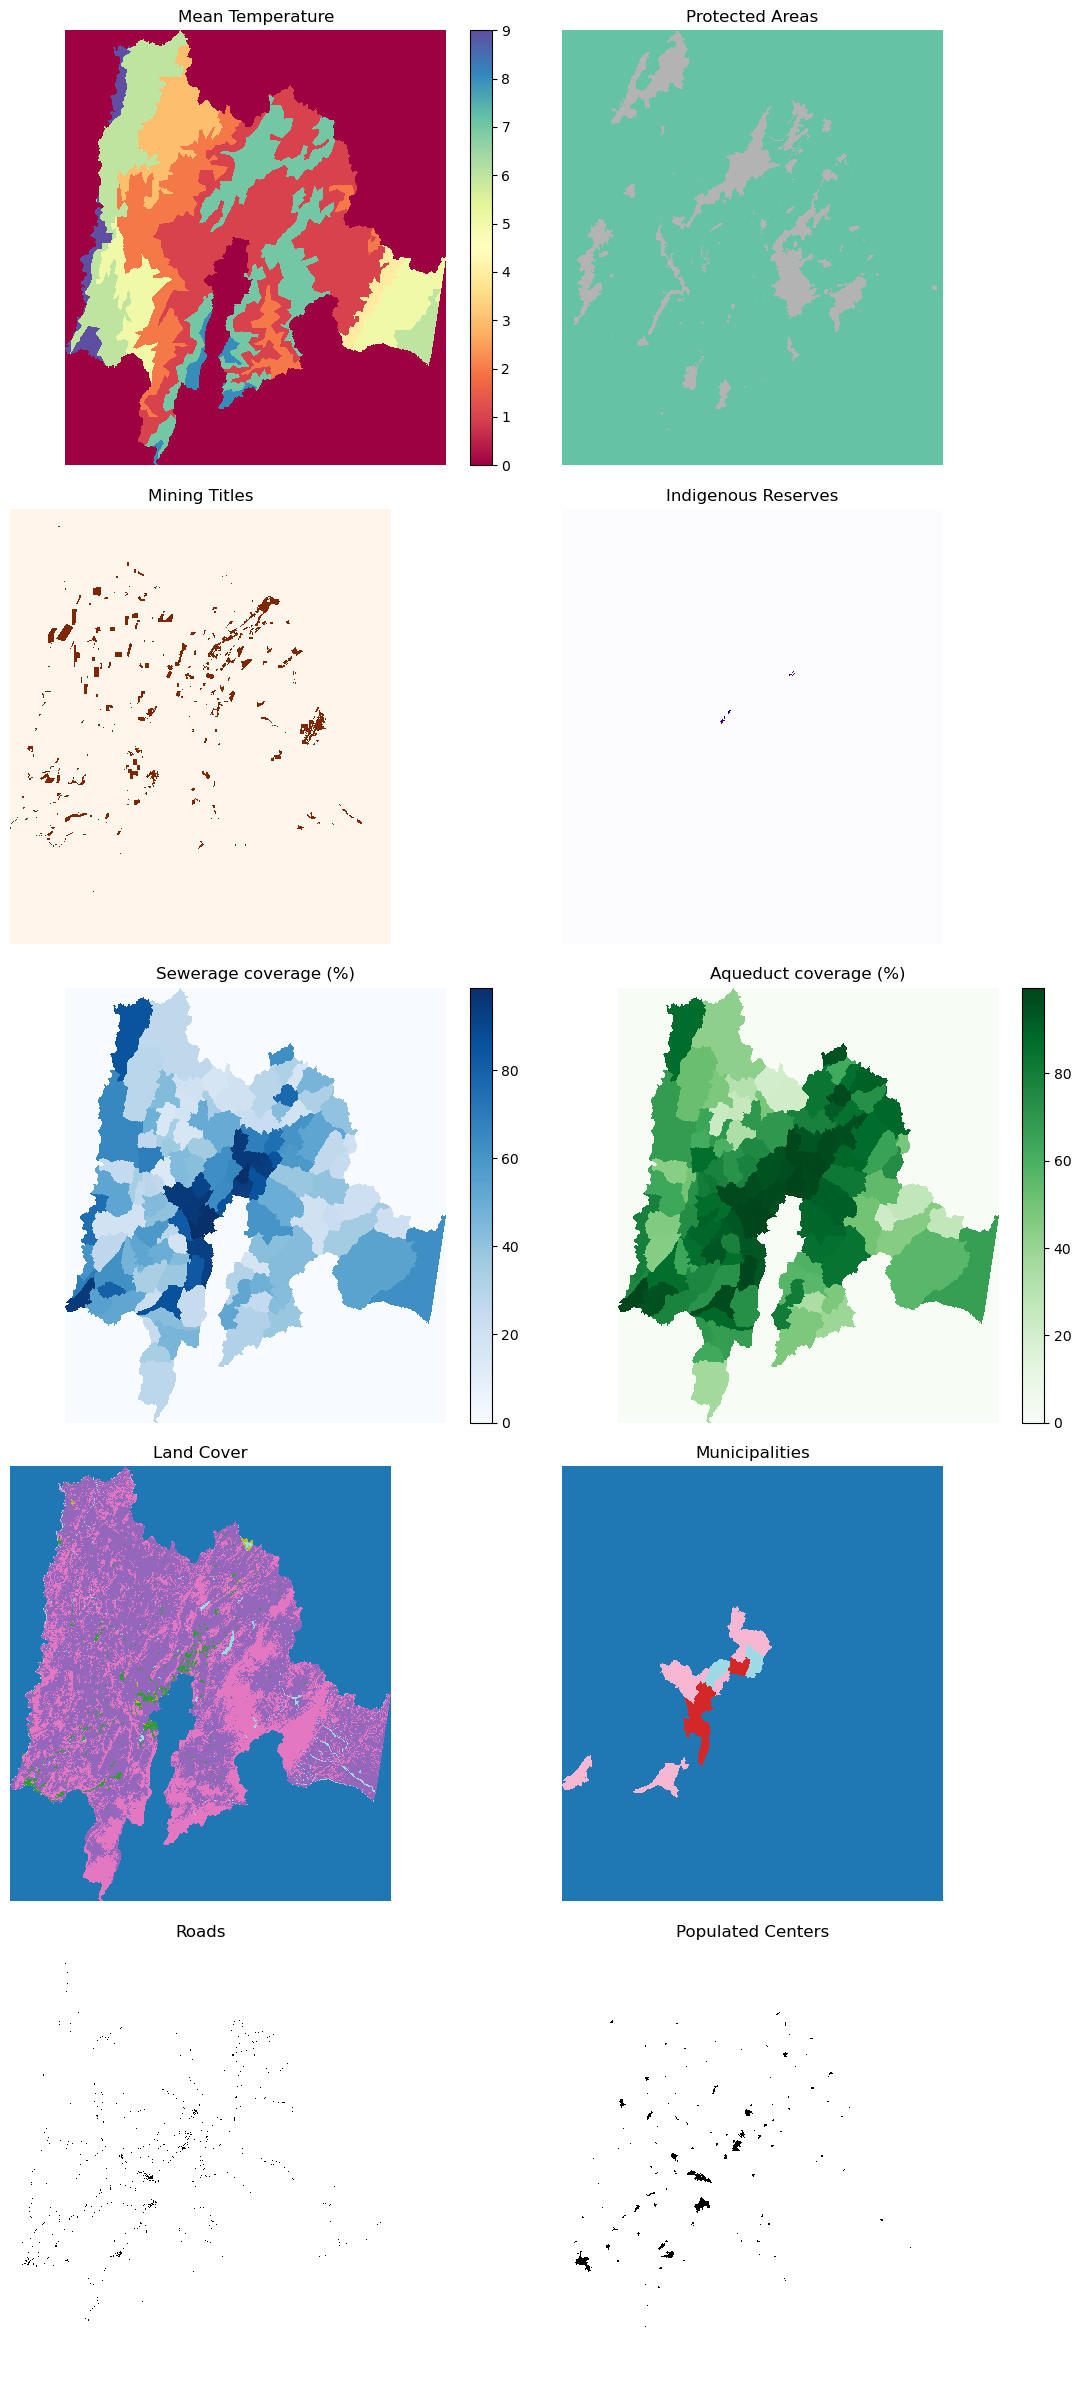

In [60]:


# Paths to your rasters
rasters = [
    ("./data/raster/temp_raster.tif", "Mean Temperature", "Spectral"),
    ("./data/raster/runap_raster.tif", "Protected Areas", "Set2"),
    ("./data/raster/min_raster.tif", "Mining Titles", "Oranges"),
    ("./data/raster/indigenous_raster.tif", "Indigenous Reserves", "Purples"),
    ("./data/raster/sewerage_raster.tif", "Sewerage coverage (%)", "Blues"),
    ("./data/raster/aqueduct_raster.tif", "Aqueduct coverage (%)", "Greens"),
    ("./data/raster/cover_raster.tif", "Land Cover", "tab20"),
    ("./data/raster/muni_raster.tif", "Municipalities", "tab20"),
    ("./data/raster/road_raster.tif", "Roads", "Greys"),
    ("./data/raster/popcenter_raster.tif", "Populated Centers", "Greys")
]

fig, axs = plt.subplots(5, 2, figsize=(12, 24))

for i, (raster_path, title, cmap) in enumerate(rasters):
    row, col = divmod(i, 2)
    with rasterio.open(raster_path) as src:
        img = src.read(1)
        # Mask nodata for display
        if src.nodata is not None:
            img = np.ma.masked_equal(img, src.nodata)
        # For categorical rasters, use discrete colormap
        if cmap in ["tab20", "Set2", "Oranges", "Purples"]:
            im = axs[row, col].imshow(img, cmap=cmap, interpolation="none")
        else:
            im = axs[row, col].imshow(img, cmap=cmap, interpolation="none")
        axs[row, col].set_title(title)
        axs[row, col].set_axis_off()
        # Add colorbar for continuous rasters
        if "coverage" in title or "Temperature" in title:
            plt.colorbar(im, ax=axs[row, col], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()